In [21]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import talib as ta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [43]:
import pandas as pd
import numpy as np
import talib as ta

def add_features(df, prefix=''):
    """为任意K线DataFrame添加一组常用特征，返回新DataFrame"""
    data = df.copy()
    data[f'{prefix}ema_20'] = data['close'] / ta.EMA(data['close'], timeperiod=20)
    data[f'{prefix}rsi_20'] = ta.RSI(data['close'], timeperiod=14) / 100
    slowk_10, slowd_10 = ta.STOCH(data['high'], data['low'], data['close'],
                                  fastk_period=10, slowk_period=3, slowk_matype=0,
                                  slowd_period=3, slowd_matype=0)
    data[f'{prefix}stoch_k_10'] = slowk_10
    data[f'{prefix}atr_20'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod=20) / data['close']
    upper, middle, lower = ta.BBANDS(data['close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
    data[f'{prefix}bb_width'] = upper - lower
    data[f'{prefix}bb_percent'] = (data['close'] - lower) / (upper - lower)
    data[f'{prefix}volatility_20'] = data['close'].rolling(window=20).std() / data['close']
    data[f'{prefix}adx_10'] = ta.ADX(data['high'], data['low'], data['close'], timeperiod=10) / 100
    data[f'{prefix}obv'] = ta.OBV(data['close'], data['volume']) / (data['volume'].rolling(window=20).mean())
    data[f'{prefix}vol_20'] = data['volume'].rolling(window=20).mean()
    data[f'{prefix}box_size'] = abs(data['close'] - data['open']) / (data['high'] - data['low'] + 1e-9)
    data[f'{prefix}high_tail_pct'] = (data['high'] - data[['close', 'open']].max(axis=1)) / (data['high'] - data['low'] + 1e-9)
    data[f'{prefix}low_tail_pct'] = (data[['close', 'open']].min(axis=1) - data['low']) / (data['high'] - data['low'] + 1e-9)
    data[f'{prefix}up_resistence'] = data['high'].rolling(window=100).max()
    data[f'{prefix}down_resistence'] = data['low'].rolling(window=100).min()
    data[f'{prefix}position'] = (data['close'] - data[f'{prefix}down_resistence']) / (data[f'{prefix}up_resistence'] - data[f'{prefix}down_resistence'] + 1e-9)
    data[f'{prefix}momentum_10'] = ta.MOM(data['close'], timeperiod=10) / data['close']
    return data

# 读取数据
df_15m = pd.read_csv('data/spot/binance/15m/BTC_USDT.csv', parse_dates=['datetime'])
df_1h = pd.read_csv('data/spot/binance/1h/BTC_USDT.csv', parse_dates=['datetime'])
df_4h = pd.read_csv('data/spot/binance/4h/BTC_USDT.csv', parse_dates=['datetime'])

df_15m.set_index('datetime', inplace=True)
df_1h.set_index('datetime', inplace=True)
df_4h.set_index('datetime', inplace=True)

# 分别加特征
feat_15m = add_features(df_15m, prefix='15m_')
feat_1h = add_features(df_1h, prefix='1h_')
feat_4h = add_features(df_4h, prefix='4h_')

# 只保留特征列（去掉原始open/high/low/close/volume等，防止未来泄漏）
feature_cols = [col for col in feat_15m.columns if col.startswith('15m_')]
features_15m = feat_15m[feature_cols]
feature_cols_1h = [col for col in feat_1h.columns if col.startswith('1h_')]
features_1h = feat_1h[feature_cols_1h].reindex(feat_15m.index, method='ffill')
feature_cols_4h = [col for col in feat_4h.columns if col.startswith('4h_')]
features_4h = feat_4h[feature_cols_4h].reindex(feat_15m.index, method='ffill')

# 合并
data_all = pd.concat([feat_15m, features_1h, features_4h], axis=1)

print(data_all.head())

                         open      high       low     close      volume  \
datetime                                                                  
2020-12-31 16:00:00  28782.01  28822.59  28615.82  28648.53  717.344939   
2020-12-31 16:15:00  28648.52  28739.94  28555.00  28641.22  675.736232   
2020-12-31 16:30:00  28641.23  28694.71  28463.33  28490.30  705.270939   
2020-12-31 16:45:00  28490.31  28551.08  28311.00  28380.60  872.029296   
2020-12-31 17:00:00  28382.47  28576.57  28362.00  28576.02  723.600007   

                     15m_ema_20  15m_rsi_20  15m_stoch_k_10  15m_atr_20  \
datetime                                                                  
2020-12-31 16:00:00         NaN         NaN             NaN         NaN   
2020-12-31 16:15:00         NaN         NaN             NaN         NaN   
2020-12-31 16:30:00         NaN         NaN             NaN         NaN   
2020-12-31 16:45:00         NaN         NaN             NaN         NaN   
2020-12-31 17:00:00     

In [44]:
data_all.to_csv('data/BTC/raw/multi_tf_features_15m_1h_4h.csv')

In [45]:
TARGET_PERIOD = 2
# T-1 到 T+4 的涨跌为目标
# >0 为正样本，<=0为负样本，符合lightgbm的二分类标记
data_all['target'] = (data_all['close'].shift(-TARGET_PERIOD) - data_all['close'] > 0).astype(int)

# # 删除含有NaN值的行
data_all.dropna(inplace=True)

In [46]:
START_DATE = '2022-06-01'
END_DATE = '2025-06-30'
# 确保时间列为datetime类型
data_all.index = pd.to_datetime(data_all.index)
data = data_all[(data_all.index >= START_DATE) & (data_all.index <= END_DATE)]

In [47]:
# 划分特征和目标
feature_cols = [col for col in data.columns if col not in ['datetime', 'target']]
X = data[feature_cols]
y = data['target']

# 只划分训练集和验证集（不再有 test）
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False)

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [48]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([45414, 46382], dtype=int64))

In [49]:
lgb_train = lgb.Dataset(X_train_scaled, y_train)
lgb_val = lgb.Dataset(X_val_scaled, y_val)

params = {
    'num_leaves': 50,  # Increase the number of leaves to allow the model to capture more complex patterns
    'min_data_in_leaf': 30,  # Reduce the minimum data in a leaf to allow smaller leaves
    'objective': 'binary',  # Correct the objective to 'binary' for binary classification
    'num_class': 1,  # Set to 1 for binary classification
    'max_depth': -1,
    'learning_rate': 0.02,
    # "min_sum_hessian_in_leaf": 5,  # Slightly reduce the minimum sum of hessian in a leaf
    "boosting": "gbdt",
    # "feature_fraction": 0.95,  # Increase feature fraction to use more features
    # "bagging_freq": 1,
    # "bagging_fraction": 0.8,  # Increase bagging fraction to use more data in each iteration
    "bagging_seed": 11,
    # "lambda_l1": 0.05,  # Reduce L1 regularization to allow more flexibility
    "verbosity": -1,
    "nthread": 4,
    'metric': 'binary_logloss',  # Use binary_logloss for binary classification
    "random_state": 2019,
    'device': 'gpu',
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=300,
    valid_sets=[lgb_train, lgb_val],
)

C:\Users\hp\AppData\Local\Temp\ipykernel_10692\2684027704.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


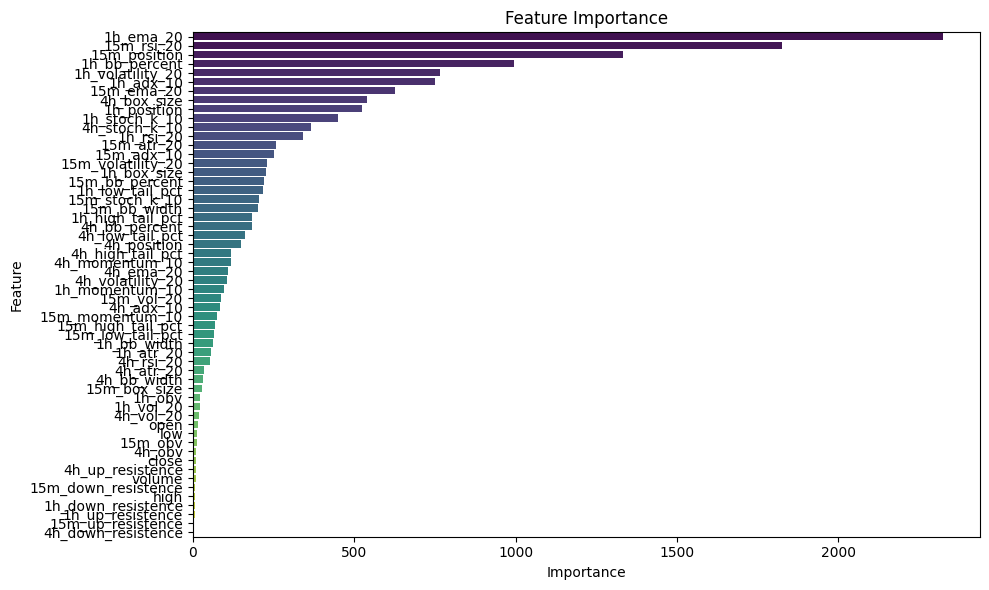

In [50]:
# Get feature importance
importance = gbm.feature_importance(importance_type='split')
feature_importance = pd.DataFrame({'Feature': feature_cols, 'Importance': importance})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Train Classification Report:
              precision    recall  f1-score   support

           0     0.7389    0.7311    0.7349     45414
           1     0.7394    0.7470    0.7432     46382

    accuracy                         0.7391     91796
   macro avg     0.7391    0.7390    0.7391     91796
weighted avg     0.7391    0.7391    0.7391     91796

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.6959    0.6988    0.6973      8002
           1     0.7048    0.7019    0.7033      8198

    accuracy                         0.7004     16200
   macro avg     0.7003    0.7004    0.7003     16200
weighted avg     0.7004    0.7004    0.7004     16200



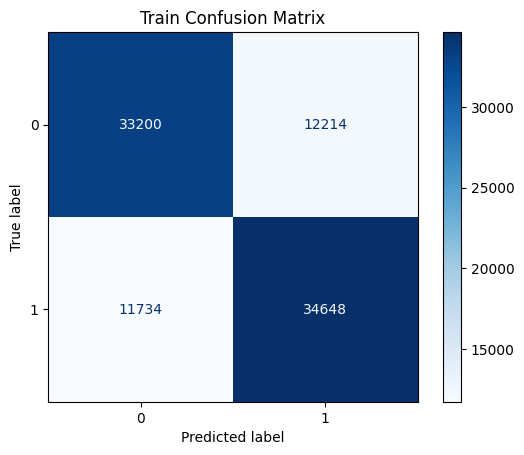

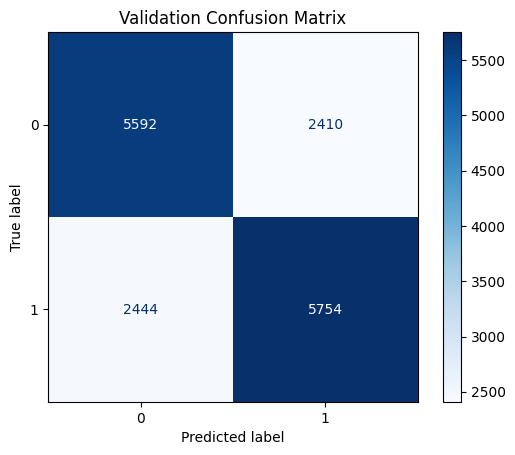

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 预测与评价
y_train_pred = gbm.predict(X_train_scaled)
y_val_pred = gbm.predict(X_val_scaled)
y_train_cls = (y_train_pred > 0.5).astype(int)
y_val_cls = (y_val_pred > 0.5).astype(int)

print("Train Classification Report:")
print(classification_report(y_train, y_train_cls, digits=4))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_cls, digits=4))

cm_train = confusion_matrix(y_train, y_train_cls)
cm_val = confusion_matrix(y_val, y_val_cls)
ConfusionMatrixDisplay(cm_train).plot(cmap='Blues')
plt.title("Train Confusion Matrix")
plt.show()
ConfusionMatrixDisplay(cm_val).plot(cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()
